In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["SNORKELHOME"] = "/afs/cs.stanford.edu/u/paroma/snorkel_new/babble_snorkel/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and Visualize Dataset
First, we load the dataset and associated bounding box objects and labels.
Note that in some cases, the resulting images from the query will be incorrectly labeled. THis is because the ground truth also comes from a crodsourced setting where relations in the image are described, and therefore prone to error.

**Make sure to run `unzip tutorial_data` before running this cell!**

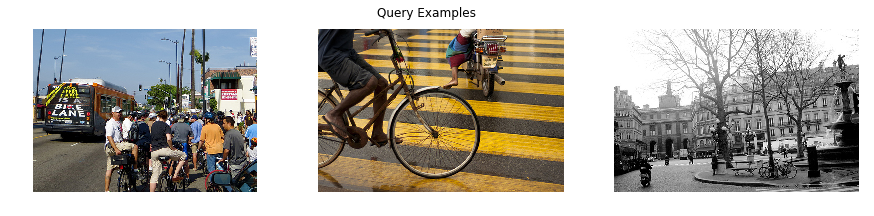

In [2]:
from data_loader import DataLoader
loader = DataLoader()

loader.show_examples(annotated=False, label=1)

## Generate Primitives
Since we cannot check relations in the images directly by writing labeling functions over the primitives, we first extract a set of  "primitives" from the images that are easily interpretable.

In this case, we use information about the objects in the data such as their labels, their positions and their size.  We show how we develop simple primitives that are based on the labels of the different objects and include the more complex primitives in `primitive_helpers.py`.

#### Membership-based Primitives
Check whether certain objects appear in the images

In [3]:
def has_bike(object_names):
    if ('cycle' in object_names) or ('bike' in object_names) or ('bicycle' in object_names):
        return 1
    else:
        return 0

In [4]:
def has_human(object_names):
    if (('person' in object_names) or ('woman' in object_names) or ('man' in object_names)) and (('bicycle' in object_names) or 'bicycles' in object_names):
        return 1
    else:
        return 0

In [5]:
def has_road(object_names):
    if ('road' in object_names) or ('street' in object_names) or ('concrete' in object_names):
        return 1
    else:
        return 0

In [6]:
def has_cars(object_names):
    if ('car' in object_names) or ('cars' in object_names) or ('bus' in object_names) or ('buses' in object_names) or ('truck' in object_names) or ('trucks' in object_names):
        return 1
    else:
        return 0

#### Object Relationship Based Primitives
These look at the relation among the bikes and the people in the images. These include checking the relative:
* number of bikes vs people
* position of bikes vs people
* size of bikes vs people

Code for the development of these primitives is included in the file `primitive_helpers.py`.

In [7]:
from primitive_helpers import *
def create_primitives(loader):
    m = 7
    primitive_mtx = np.zeros((loader.train_num,m))

    for i in xrange(loader.train_num):
        primitive_mtx[i,0] = has_human(loader.train_object_names[i])
        primitive_mtx[i,1] = has_road(loader.train_object_names[i])
        primitive_mtx[i,2] = has_cars(loader.train_object_names[i])
        primitive_mtx[i,3] = has_bike(loader.train_object_names[i])

        primitive_mtx[i,4] = bike_human_distance(loader.train_object_names[i], 
                                                 loader.train_object_x[i], 
                                                 loader.train_object_y[i])

        area = np.multiply(loader.train_object_height[i], loader.train_object_width[i])
        primitive_mtx[i,5] = bike_human_size(loader.train_object_names[i], area)
        primitive_mtx[i,6] = bike_human_nums(loader.train_object_names[i])
        
    P = PrimitiveObject()
    P.save_primitive_matrix(primitive_mtx)
    return P

**Assign and Name Primitives**
We assign the primitives and name them according to the variables we will use to refer to them in the heuristic functions we develop next. 

For example, `primitive_mtx[i,0]` is referred to as `has_human`.

In [8]:
P = create_primitives(loader)
primitive_names = ['has_human', 'has_road', 'has_cars', 'has_bike', 
                   'bike_human_distance', 'bike_human_size', 'bike_human_num']

## Heuristic Functions
We now develop heuristic functions that take different primitives in as inputs and apply a label based on the value of those primitives. 

In [9]:
def LF_street(has_human, has_road):
    if has_human >= 1: 
        if has_road >= 1:
            return 1
        else:
            return -1
    return 0

def LF_vehicles(has_human, has_cars):
    if has_human >= 1: 
        if has_cars >= 1:
            return 1
        else:
            return -1
    return 0

def LF_distance(has_human, has_bike, bike_human_distance):
    if has_human >= 1:
        if has_bike >= 1: 
            if bike_human_distance <= np.sqrt(8):
                return 1
            else:
                return 0
    else:
        return -1
    
def LF_size(has_human, has_bike, bike_human_size):
    if has_human >= 1:
        if has_bike >= 1: 
            if bike_human_size <= 1000:
                return -1
            else:
                return 0
    else:
        return -1
    
    
def LF_number(has_human, has_bike, bike_human_num):
    if has_human >= 1:
        if has_bike >= 1: 
            if bike_human_num >= 2:
                return 1
            if bike_human_num >= 1:
                return 0
            if bike_human_num >= 0:
                return 1
    else:
        return -1

**Assign Heuristic Functions**

We create a list of the functions we used in `L_names` and apply the heuristic functions to the appropriate primitives to generate `L`, a _labeling matrix_.

In [10]:
L_names = [LF_street,LF_vehicles,LF_distance,LF_size,LF_number]

L = np.zeros((len(L_names),loader.train_num))
for i in xrange(loader.train_num):
    L[0,i] = LF_street(P.primitive_mtx[i,0],P.primitive_mtx[i,1])
    L[1,i] = L_names[1](P.primitive_mtx[i,0],P.primitive_mtx[i,2])
    L[2,i] = L_names[2](P.primitive_mtx[i,0],P.primitive_mtx[i,3], P.primitive_mtx[i,4])
    L[3,i] = L_names[3](P.primitive_mtx[i,0],P.primitive_mtx[i,3], P.primitive_mtx[i,5])
    L[4,i] = L_names[4](P.primitive_mtx[i,0],P.primitive_mtx[i,3], P.primitive_mtx[i,6])

**Calculate and Show Accuracy and Coverage of Heuristic Functions**

In [11]:
total = float(loader.train_num)

stats_table = np.zeros((5,2))
for i in range(5):
    stats_table[i,1] = np.sum(L[i,:] == loader.train_ground)/float(np.sum(L[i,:] != 0))
    stats_table[i,0] = np.sum(L[i,:] != 0)/total

In [12]:
import pandas as pd
stats_table = pd.DataFrame(stats_table, index = [i.__name__ for i in L_names], columns = ["Coverage", "Accuracy"])
stats_table

,Coverage,Accuracy
LF_street,0.444075,0.663342
LF_vehicles,0.444075,0.680798
LF_distance,0.609081,0.747273
LF_size,0.573643,0.770270
LF_number,0.712071,0.690513


## Generate Training Set

In [13]:
from snorkel.learning import GenerativeModel
from scipy import sparse
import matplotlib.pyplot as plt

L_train = sparse.csr_matrix(L.T)

/dfs/scratch0/paroma/anaconda2/envs/babble/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


**Majority Vote**

To get a sense of how well our heuristic functions are, we calcuate the accuracy of the training set labels if we took the majority vote label for each data point.

In [15]:
mv_labels = np.sign(np.sum(L.T,1))
print 'Coverage of Majority Vote on Train Set: ', np.sum(np.sign(np.sum(np.abs(L.T),1)) != 0)/float(loader.train_num)
print 'Accuracy of Majority Vote on Train Set: ', np.sum(mv_labels == loader.train_ground)/float(loader.train_num)

Coverage of Majority Vote on Train Set:  1.0
Accuracy of Majority Vote on Train Set:  0.6744186046511628


**Generative Model**
We assume that the heuristic functions are conditionally independent of the true label and train the generative model using the labels assigned by the heuristic functions

In [30]:
gen_model = GenerativeModel()

gen_model.train(L.T, epochs=100, decay=0.95, step_size= 0.01/ L.shape[1], reg_param=1e-6)
train_marginals = gen_model.marginals(L_train)

Inferred cardinality: 2


**Probabilistic Label Statistics**

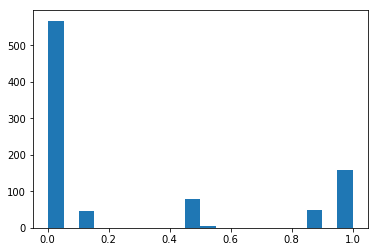

In [31]:
plt.hist(train_marginals, bins=20)
plt.show()

In [32]:
learned_table = gen_model.learned_lf_stats()
complete_stats = pd.DataFrame(np.hstack((learned_table.as_matrix()[:,0:2], stats_table.as_matrix()[:,[1,0]])), 
                              index = [i.__name__ for i in L_names], 
                              columns=['Learn. Acc.', 'Learn. Cov.', 'Emp. Acc.', 'Emp. Cov.'])
complete_stats

,Learn. Acc.,Learn. Cov.,Emp. Acc.,Emp. Cov.
LF_street,0.880085,0.7497,0.663342,0.444075
LF_vehicles,0.883451,0.7499,0.680798,0.444075
LF_distance,0.879707,0.7515,0.747273,0.609081
LF_size,0.880121,0.7591,0.770270,0.573643
LF_number,0.880842,0.7553,0.690513,0.712071


In [33]:
labels = 2 * (train_marginals > 0.9) - 1
print 'Coverage of Generative Model on Train Set:', np.sum(train_marginals != 0.5)/float(len(train_marginals))
print 'Accuracy of Generative Model on Train Set:', np.mean(labels == loader.train_ground)

Coverage of Generative Model on Train Set: 1.0
Accuracy of Generative Model on Train Set: 0.7486157253599114
